Importation des packages

In [1]:
!pip install py7zr geojson geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-gahl9o4g
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-gahl9o4g
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
import geopandas as gpd
import geojson
import requests
import time
import os
import re
import magic
import matplotlib.pyplot as plt
import zipfile
import cartiflette
from io import StringIO

This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


Description des variables de ce dataframe :
- idmutinvar = identifiant unique entre les diff bases pour retrouver chaque mutation
- idopendata = identifiant de mutation utilisé depuis l'ouverture de données DVF
- datemut = date de signature de l'acte de vente
- anneemut = annee de signature du doc
- codedep
- libnatmut = Libellé de nature de mutation tel que défini dans la donnée source DVF 6 catégories : Vente, Vente en l'état futur d'achèvement, Adjudication, Echange, Vente terrain à bâtir et Expropriation.
- vefa = booléen selon si la vente est en VEFA (vente en l'état futur d'achèvement) ou non
- valeurfonc = valeur foncière en euro déclarée lors de la vente ; prix net vendeur, inclut la TVA mais n'inclut pas les frais de notaire, d'agence ou des meubles. 
- nbcomm = nombre de communes concernée par la mutation (i.e. sur lesquelles se trouve la parcelle cadastrale concernée par la mutation)
- nbpar = comme nbcomm mais pour les parcelles.
- nbparmut = nb de parcelles ayant muté (i.e. dont la pleine propriété a été transférée lors de la mutation)
- sterr = surface de terrain ayant muté (mutation = transfert de propriété, donc surface de terrain ayant muté = surface du terrain qui a été vendu)
- nbvolmut = variable obscure, flemme 
- nblocmut = nb de locaux ayant muté
- sbati = surface de l'ensemble du bati ayant muté
- codtypbien = typologie des biens ; on pourra s'en servir pour filter les maisons et appartements et virer tous les types de batiments bizarres (cf schéma ici) https://doc-datafoncier.cerema.fr/doc/dv3f/mutation/codtypbien
- libtypbien = comme codtypbien mais pour la base DV3F et non issu de juste DVF
- geometry
- l_codeinsee = liste des codes INSEE des communes concernées par la mutation
- l_idpar =Liste des idpar qui composent l’entité (idpar = Identifiant de parcelle)
- l_idparmut = liste des identifiants de parcelles ayant muté (idpar)
- l_idlocmut = liste des identifiants de locaux ayant muté (idloc)

On veut d'abord récupérer les données de la base DVF à partir de l'API publique dédiée. On peut regarder la documentation de cette API sur le site suivant : 
https://apidf-preprod.cerema.fr/swagger/#/DVF%2B%20(acc%C3%A8s%20libre)/dvf_opendata_geomutations_list


1. Importation des données DVF

A. Paramétrage de l'API

In [ ]:
def cleaning_json_for_gpd(data):
    for feature in data["features"]:
        properties = feature["properties"]
        for key, value in properties.items():
            if isinstance(value, list):  # Vérifie si c'est une liste
                properties[key] = ", ".join(map(str, value))  # Convertit en chaîne séparée par des virgules

In [3]:
def recup_donnees_dvf(code_insee,annee_mut):
        url = base_api_dvf_url + f"/dvf_opendata/geomutations/?anneemut={annee_mut}&code_insee={code_insee}&page_size=300"
        response = requests.get(url)
        data = response.json()
        cleaning_json_for_gpd(data)
        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
        col_mut = mut_gdf_tempo.columns
        mut_gdf = gpd.GeoDataFrame(columns=col_mut)

        while url != None : 
                response = requests.get(url)
                if response.status_code == 200:
                        data = response.json()
                        url = data['next']
                        cleaning_json_for_gpd(data) #transforme le dictionary qu'est data en un dataframe
                        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
                        mut_gdf = pd.concat([mut_gdf, mut_gdf_tempo], axis=0)
                    
                else:
                        print(f"Erreur : {response.status_code}")
                        url = None

        return mut_gdf

In [4]:
def recup_donnees_dvf_all_years(code_insee):
        url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=500"
        response = requests.get(url)
        data = response.json()
        cleaning_json_for_gpd(data)
        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
        col_mut = mut_gdf_tempo.columns
        mut_gdf = gpd.GeoDataFrame(columns=col_mut)

        while url != None : 
                response = requests.get(url)
                if response.status_code == 200:
                        data = response.json()
                        url = data['next']
                        print(url)
                        cleaning_json_for_gpd(data) #transforme le dictionary qu'est data en un dataframe
                        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
                        mut_gdf = pd.concat([mut_gdf, mut_gdf_tempo], axis=0)
                    
                else:
                        print(f"Erreur : {response.status_code}")
                        url = None

        return mut_gdf

On écrit la racine de l'API : 

In [9]:
base_api_dvf_url = "https://apidf-preprod.cerema.fr"

On va récupérer les données DVF des villes suivantes : 
1. Zone ouest :
- Paris 16 : 75116
- Paris 17: 75117
- Clichy : 92024
- Levallois : 92044
- Neuilly : 92051
- Boulogne-Billancourt : 92012

2. Zone sud
- Paris 13 : 75113
- Paris 14 : 75114
- Paris 15 : 75115
- Issy-les-Moulineaux : 92040
- Vanves : 92075
- Malakoff : 92046
- Montrouge : 92049
- Gentilly : 94037
- Ivry-sur-Seine : 94041


On constate en faisant tourner naïvement l'API qu'on obtient toujours des données par paquets en nombre limité (par défaut, 100). On peut modifier cela par le paramètre "page_size", mais la limite est de 500. Pour un paramètre supérieur à 500, on n'obtient que des pages de 500. 

On cherche donc à faire boucler nos requêtes à l'API jusqu'à obtenir toutes les données concernant la commune qui nous intéresse. Or on constate que la réponse "data" que l'on obtient possède une clé "next", qui donne l'url de notre requête complété par un argument "page". L'API fonctionne donc ainsi : s'il y a plus de 500 observations pour une commune, l'API nous renvoie une première page qui contient 500 observations, avec l'url pour requêter la page suivant qui contient 500 autres observations, et ainsi de suite jusqu'à la dernière page, qui donne pour valeur "None" à la clé "next". 

Le code ci-dessous permet de récupérer les données.

In [66]:
data_dvf_sud = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_sud = ["92040", "92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape

In [104]:
data_dvf_sud = recup_donnees_dvf_all_years("92040") 

code_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    data_temp = recup_donnees_dvf_all_years(code_insee_ville)
    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape

In [70]:
data_dvf_sud.shape

(11307, 22)

Difficulté : l'API peut arrêter de nous répondre de manière imprévue au milieu de la boucle de requête des pages. Dans ce cas, toutes les données obtenues sur les pages précédentes sont perdues. On a donc intérêt, pour pouvoir travailler sereinement, à télécharger ces données. 

Pour ce faire, on va essayer, commune par commune, de requêter toutes les pages, et, AVANT de passer au requêtage pour la commune suivante, on sauvegarde notre geodataframe au format geojson. 

In [ ]:
code_insee_pour_enregistre = ["92012"]
for code_insee in code_insee_pour_enregistre: 
    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"
    response = requests.get(url)
    data = response.json()
    print(data['count'])
    gdf = recup_donnees_dvf_all_years(code_insee)
    name = f'data/dvf/data_code_insee={code_insee}.geojson'
    gdf.to_file(name, driver="GeoJSON")
    gdf = gpd.read_file(name)
    print(len(gdf))

<class 'dict'>
23588


NameError: name 'recup_donnees_dvf_all_years' is not defined

In [106]:
f = open('data/donnees_dvf_sud.geojson')
data_dvf_sud = geojson.load(f)

In [107]:
type(data_dvf_sud)

geojson.feature.FeatureCollection

In [108]:
cleaning_json_for_gpd(data_dvf_sud)

In [109]:
type(data_dvf_sud)

geojson.feature.FeatureCollection

In [ ]:
print(data_dvf_sud['anneemut'].unique())
print(data_dvf_sud['l_codinsee'].unique())

On fait pareil pour la zone ouest de Paris

In [ ]:
data_dvf_ouest_banlieue = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_ouest = ["92040", "92075", "92046", "92049", "94037", "94041"]

for code_insee_ville in code_insee_ville_banlieue_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest = pd.concat([data_dvf_ouest, data_temp], axis = 0)

data_dvf_ouest_banlieue.shape

In [ ]:
data_dvf_ouest_paris = recup_donnees_dvf("75116",2012)

code_insee_arrond_ouest = ["75116", "75117"]

for code_insee_ville in code_insee_arrond_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest_paris = pd.concat([data_dvf_ouest_paris, data_temp], axis = 0)


Ci-dessous, le code pour reconstituer les fichiers geojson à partir des sauvegardes faites à cause de l'API défectueuse (en deux temps : la zone ouest puis la zone sud)

In [5]:

list_gpd_ouest = []
for geo_file in os.listdir("data/dvf/cluster_ouest"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_ouest/"+geo_file)  
    list_gpd_ouest.append(geo_file_temp)

all_gpd_ouest = pd.concat(list_gpd_ouest)
all_gpd_ouest.head()

,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,l_codinsee,...,nbparmut,l_idparmut,sterr,nbvolmut,nblocmut,l_idlocmut,sbati,codtypbien,libtypbien,geometry
0,d94fa3a8862d24c2c4b9631363827cb0,d94fa3a8862d24c2c4b9631363827cb0,2024-01-16,2024,92,Vente,False,42000.00,1,92051,...,0,None,0.00,0,1,920510019537055_0,0.00,131,UNE DEPENDANCE,"MULTIPOLYGON (((2.25973 48.88875, 2.2597 48.88..."
1,118605f8b2f4979f8ebc30170ee2b0f0,118605f8b2f4979f8ebc30170ee2b0f0,2024-03-11,2024,92,Vente,False,1096100.00,1,92051,...,0,None,0.00,0,4,"920510019541375_0, 920510019541376_0, 92051001...",86.00,121,UN APPARTEMENT,"MULTIPOLYGON (((2.26912 48.89323, 2.26914 48.8..."
2,b9a2adbaab1a76cf33f430f4f4ee34b6,b9a2adbaab1a76cf33f430f4f4ee34b6,2024-06-24,2024,92,Vente,False,1090000.00,1,92051,...,0,None,0.00,0,2,"920510019547866_0, 920510019547867_0",79.00,121,UN APPARTEMENT,"MULTIPOLYGON (((2.27436 48.88426, 2.27432 48.8..."
3,cf626a4b943e08f3de46fce5e7a2fc93,cf626a4b943e08f3de46fce5e7a2fc93,2024-03-12,2024,92,Vente,False,1844400.00,1,92051,...,0,None,0.00,0,5,"920510019542326_0, 920510019542327_0, 92051001...",128.00,122,DEUX APPARTEMENTS,"MULTIPOLYGON (((2.26675 48.88981, 2.26659 48.8..."
4,d5882fb38e38534fdb9f23f2ac04652d,d5882fb38e38534fdb9f23f2ac04652d,2024-05-28,2024,92,Vente,False,1487800.00,1,92051,...,0,None,0.00,0,4,"920510019546937_0, 920510019546938_0, 92051001...",93.00,121,UN APPARTEMENT,"MULTIPOLYGON (((2.26492 48.88494, 2.26495 48.8..."


In [6]:
all_gpd_ouest.shape

(134410, 22)

In [7]:
list_gpd_sud = []
for geo_file in os.listdir("data/dvf/cluster_sud"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_sud/"+geo_file)  
    print(geo_file_temp.shape)
    list_gpd_sud.append(geo_file_temp)

all_gpd_sud = pd.concat(list_gpd_sud)
all_gpd_sud.head()

(8338, 22)
(11307, 22)
(18482, 22)
(41235, 22)
(3916, 22)
(8416, 22)
(20219, 22)
(5124, 22)
(2282, 22)


,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,l_codinsee,...,nbparmut,l_idparmut,sterr,nbvolmut,nblocmut,l_idlocmut,sbati,codtypbien,libtypbien,geometry
0,95a6760ed10c9de595b655e8f1db703f,95a6760ed10c9de595b655e8f1db703f,2024-05-14,2024,92,Vente,False,38000.00,1,92049,...,0,None,0.00,0,1,920490019554982_0,0.00,131,UNE DEPENDANCE,"MULTIPOLYGON (((2.31801 48.81246, 2.3182 48.81..."
1,4a37e862dcb628c7b473b474b6dbb3ed,4a37e862dcb628c7b473b474b6dbb3ed,2024-02-26,2024,92,Vente,False,18000.00,1,92049,...,0,None,0.00,0,1,920490019551066_0,0.00,131,UNE DEPENDANCE,"MULTIPOLYGON (((2.32732 48.81573, 2.32739 48.8..."
2,9711e8d4ccc5c4dfa867545f65cc28c3,9711e8d4ccc5c4dfa867545f65cc28c3,2024-03-19,2024,92,Vente,False,220000.00,1,92049,...,0,None,0.00,0,2,"920490019551809_0, 920490019551810_0",26.00,121,UN APPARTEMENT,"MULTIPOLYGON (((2.30663 48.8163, 2.30658 48.81..."
3,ff355bdd9fdf67cc54c7d4e90bad115d,ff355bdd9fdf67cc54c7d4e90bad115d,2024-05-27,2024,92,Vente,False,518000.00,1,92049,...,0,None,0.00,0,3,"920490019555447_0, 920490019555448_0, 92049001...",64.00,121,UN APPARTEMENT,"MULTIPOLYGON (((2.30994 48.81089, 2.30995 48.8..."
4,14b9a2c07cfe462e0a6a34bc3f87b6eb,14b9a2c07cfe462e0a6a34bc3f87b6eb,2024-06-04,2024,92,Vente,False,540000.00,1,92049,...,0,None,0.00,0,2,"920490019556566_0, 920490019556567_0",67.00,121,UN APPARTEMENT,"MULTIPOLYGON (((2.31247 48.82075, 2.31248 48.8..."


In [26]:
all_gpd_sud.shape

(119319, 22)

B. Nettoyage des jeux de données téléchargés

Les colonnes ont pour la plupart des types "object" qui nous empêchent de travailler : 

In [18]:
mut_gdf.dtypes

geometry      geometry
idmutinvar      object
idopendata      object
datemut         object
anneemut         int64
coddep          object
libnatmut       object
vefa              bool
valeurfonc      object
nbcomm           int64
l_codinsee      object
nbpar            int64
l_idpar         object
nbparmut         int64
l_idparmut      object
sterr           object
nbvolmut         int64
nblocmut         int64
l_idlocmut      object
sbati           object
codtypbien      object
libtypbien      object
dtype: object

On peut changer le type d'une colonne en un autre type à spécifier. Par exemple, pour changer 'sterr' en décimaux : 

In [19]:
mut_gdf['sterr']  = mut_gdf["sterr"].astype(float)

On peut vérifier :

In [ ]:
mut_gdf.dtypes

In [21]:
mut_gdf_old.shape

(272, 18)

2. Récupération de données Insee par IRIS pour avoir des variables de contrôle dans notre régression

Il n'y a pas d'API permettant de récupérer les données voulues par IRIS, donc on doit passer par l'importation de tous les fichiers. On importe deux types de fichiers : un qui contient des informations sur le revenu disponible (TROUVER LE NOM) et un qui donne des informations sur l'état du logement de l'IRIS (TROUVER NOM).

In [64]:
dfs_activite = []
dfs_logement = []
dfs_revenu = []

for f in os.listdir("data/insee"):
    if f == "base-ic-logement-2017_csv.zip" : 
        pass
    else : 
        if f.lower().endswith(".zip"): #si c'est un zip
            print(f)
            zip_file = zipfile.ZipFile("data/insee/"+f) #on le dézipe
            nom_racine_dossier = f.rsplit(".",1)[0]
            for f_in_zip in zipfile.ZipFile("data/insee/"+f).namelist():
                if f_in_zip[0:4] == "meta" :
                    pass
                else :
                    nom_racine_fichier = f_in_zip.rsplit(".",1)[0]
                    extension = f_in_zip.rsplit(".",1)[1] #on récupère l'extension
                    
                    # Recherche de l'année
                    schema_date = r"(\d{4})"
                    match = re.search(schema_date, f)
                        
                    annee_extraite = match.group(1)
                    if extension.lower() == "csv":
                        df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")
                    elif extension in ("xls", "xlsx"):
                        df_temp = pd.read_excel(zip_file.open(nom_racine_fichier + "." + extension),
                                    skiprows = 5)
                    deux_derniers_chiffres_annee = annee_extraite[2:4]
                    df_temp['annee'] = annee_extraite
                    
                    

                    if "activite" in nom_racine_fichier:
                        df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                        dfs_activite.append(df_temp)
                    elif "logement" in nom_racine_fichier:
                        df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                        dfs_logement.append(df_temp)
                    elif "DISP" in nom_racine_fichier:
                        colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
                        df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})

                        dfs_revenu.append(df_temp)
                    else :
                        print('un fichier n a pas été traité')


base-ic-activite-residents-2019_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


BASE_TD_FILO_IRIS_2021_DISP_CSV.zip
BASE_TD_FILO_DISP_IRIS_2020_XLSX.zip
base-ic-activite-residents-2015.zip
base-ic-activite-residents-2020_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


BASE_TD_FILO_DISP_IRIS_2018.zip
base-ic-logement-2018_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


BASE_TD_FILO_DISP_IRIS_2020_CSV.zip
base-ic-activite-residents-2014.zip
base-ic-logement-2015.zip
base-ic-logement-2021_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,3,80,81,82,83,84,85,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


base-ic-activite-residents-2021_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


base-ic-logement-2014.zip
base-ic-activite-residents-2018_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


BASE_TD_FILO_DISP_IRIS_2019.zip
base-ic-logement-2020_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


base-ic-logement-2016.zip
base-ic-logement-2019_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


base-ic-activite-residents-2016.zip
base-ic-activite-residents-2017_csv.zip


/tmp/ipykernel_68099/3375566689.py:26: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), sep = ";")


In [65]:
dfs_clean_activite = pd.concat(dfs_activite, ignore_index = True)
dfs_clean_revenu = pd.concat(dfs_revenu, ignore_index = True)
dfs_clean_logement = pd.concat(dfs_logement, ignore_index = True)

In [66]:
print(dfs_clean_activite.shape)
print(dfs_clean_revenu.shape)
print(dfs_clean_logement.shape)


(395824, 131)
(72952, 34)
(346544, 120)


In [ ]:
df_all_insee_init = dfs[0]
print(df_all_insee_init.shape)

for i in range(1,len(dfs)):
    df_all_insee_init = df_all_insee_init.merge(dfs[i], how = "outer", on = ["IRIS", "annee"])
    print(df_all_insee_init.shape)

(49282, 121)
(0, 150)
(0, 181)
(0, 294)


MergeError: Passing 'suffixes' which cause duplicate columns {'COM_x'} is not allowed.

In [5]:
df_all_insee_init.shape

(143782, 1620)

3. Fusion de nos deux jeux de données


Troisième et dernière étape d'importation des données : un fichier pour faire la correspondance entre les adresses/coordonnées des données DVF et les IRIS des données Insee.

On utilise un fichier des données géographiques des IRIS d'Île-de-France.

In [3]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [31]:
print(all_gpd_sud["geometry"].crs)
print(all_gpd_ouest["geometry"].crs)

EPSG:4326
EPSG:4326


Ok, on est bien en format 4326 (=WGS 84) pour les deux fichiers, on va pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite relier ça aux fichiers Insee)

In [15]:
data_mut_sud_avec_iris = gpd.sjoin(all_gpd_sud, iris, how="left", predicate="intersects")
data_mut_ouest_avec_iris = gpd.sjoin(all_gpd_ouest, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_sud_avec_iris.head())
print(data_mut_sud_avec_iris.columns)

                         idmutinvar                        idopendata  \
0  95a6760ed10c9de595b655e8f1db703f  95a6760ed10c9de595b655e8f1db703f   
1  4a37e862dcb628c7b473b474b6dbb3ed  4a37e862dcb628c7b473b474b6dbb3ed   
2  9711e8d4ccc5c4dfa867545f65cc28c3  9711e8d4ccc5c4dfa867545f65cc28c3   
3  ff355bdd9fdf67cc54c7d4e90bad115d  ff355bdd9fdf67cc54c7d4e90bad115d   
4  14b9a2c07cfe462e0a6a34bc3f87b6eb  14b9a2c07cfe462e0a6a34bc3f87b6eb   

     datemut anneemut coddep libnatmut   vefa valeurfonc nbcomm l_codinsee  \
0 2024-05-14     2024     92     Vente  False   38000.00      1      92049   
1 2024-02-26     2024     92     Vente  False   18000.00      1      92049   
2 2024-03-19     2024     92     Vente  False  220000.00      1      92049   
3 2024-05-27     2024     92     Vente  False  518000.00      1      92049   
4 2024-06-04     2024     92     Vente  False  540000.00      1      92049   

   ...                                           geometry index_right  \
0  ...  MULTIPOLYGO

In [19]:
print(data_mut_sud_avec_iris['code_iris'].head())

0    920490111.0
1    920490110.0
2    920490103.0
3    920490115.0
4    920490102.0
Name: code_iris, dtype: float64


Les iris apparaissent bien dans le fichier des mutations

Dernière étape : relier ça aux données Insee "test" (celle des revenus disp de 2020)

In [28]:
data_mut_sud_et_insee = pd.merge(left = data_mut_sud_avec_iris,
                            right = dfs[0], 
                            how = "left",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])

In [29]:
data_mut_sud_et_insee.head()

,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,l_codinsee,...,P19_ACTOCC15P_ILT4,P19_ACTOCC15P_ILT5,C19_ACTOCC15P,C19_ACTOCC15P_PAS,C19_ACTOCC15P_MAR,C19_ACTOCC15P_VELO,C19_ACTOCC15P_2ROUESMOT,C19_ACTOCC15P_VOIT,C19_ACTOCC15P_TCOM,annee
0,95a6760ed10c9de595b655e8f1db703f,95a6760ed10c9de595b655e8f1db703f,2024-05-14,2024,92,Vente,False,38000.00,1,92049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4a37e862dcb628c7b473b474b6dbb3ed,4a37e862dcb628c7b473b474b6dbb3ed,2024-02-26,2024,92,Vente,False,18000.00,1,92049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9711e8d4ccc5c4dfa867545f65cc28c3,9711e8d4ccc5c4dfa867545f65cc28c3,2024-03-19,2024,92,Vente,False,220000.00,1,92049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ff355bdd9fdf67cc54c7d4e90bad115d,ff355bdd9fdf67cc54c7d4e90bad115d,2024-05-27,2024,92,Vente,False,518000.00,1,92049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14b9a2c07cfe462e0a6a34bc3f87b6eb,14b9a2c07cfe462e0a6a34bc3f87b6eb,2024-06-04,2024,92,Vente,False,540000.00,1,92049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
data_mut_et_insee.head(5)

,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,nbpar,...,DISP_PCHO20,DISP_PBEN20,DISP_PPEN20,DISP_PPAT20,DISP_PPSOC20,DISP_PPFAM20,DISP_PPMINI20,DISP_PPLOGT20,DISP_PIMPOT20,DISP_NOTE20
0,72f7d15beebbeaaf8a5002f32fb5fbe0,72f7d15beebbeaaf8a5002f32fb5fbe0,2024-02-07,2024,92,Vente,False,412000.00,1,1,...,"3,7","2,9","27,9","6,4","10,3","3,5","4,7","2,1","-12,3",0
1,57693d6d16e8a1d057c73ba86ca6f6c9,57693d6d16e8a1d057c73ba86ca6f6c9,2024-03-13,2024,92,Vente,False,18000.00,1,1,...,"4,4","2,3","24,8","6,0","12,7","3,9","5,9","2,9","-11,8",0
2,bb0aac068a3309cc4471f2c355e5ea78,bb0aac068a3309cc4471f2c355e5ea78,2024-01-29,2024,92,Vente,False,389000.00,1,1,...,"3,8","3,4","28,0","6,5","8,7","3,0","3,7","2,0","-13,9",0
3,a2ef34c10ee5f970b715b8ec51b099e7,a2ef34c10ee5f970b715b8ec51b099e7,2024-01-24,2024,92,Vente,False,435000.00,1,1,...,"2,8","3,8","25,0","10,8","4,7","2,0","1,9","0,8","-17,0",0
4,97fb1518ba1ddb078df9dbfae40a0a8c,97fb1518ba1ddb078df9dbfae40a0a8c,2024-03-29,2024,92,Vente,False,162000.00,1,1,...,"4,9","1,7","24,1","6,5","6,0","1,5","3,0","1,5","-13,0",0


On commence à faire vite-fait un peu de visualisation spatiale

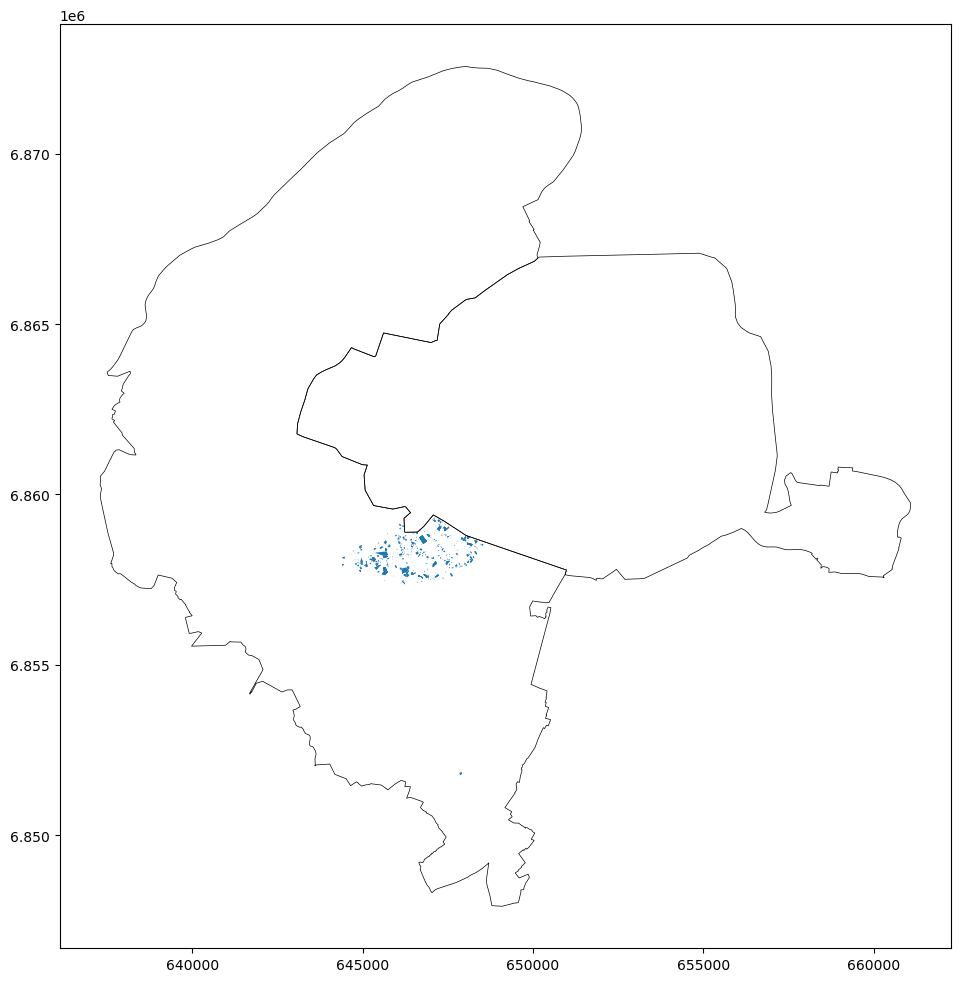

In [137]:
idf = cartiflette.carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements_paris_92 = idf.loc[
    idf["INSEE_DEP"].isin(["75", "92"])
].to_crs(2154)

fig, ax = plt.subplots(figsize=(12, 12))
base = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))

data_mut_et_insee_pour_vis = data_mut_et_insee
data_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)

data_mut_et_insee_pour_vis.plot(ax=ax)

plt.show()



On a sélectionné ici au début du code les villes de Vanves et Issy les Moulineaux, d'où le fait que les tâches de couleur s'affichent sur une zone localisée (uniquement les villes concernées)
= > il faudra ajuster l'API et le fond de carte selon la commune choisie, mais au moins on sait le faire fonctionner grosso modo